<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture2/weight_init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 重み初期化

In [1]:
# googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Deep_Learning/DL_Lecture2

/content/drive/MyDrive/Deep_Learning/DL_Lecture2


In [3]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.nn import init
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch import nn, optim
import torchvision
from torchvision import transforms

%load_ext autoreload
%autoreload 2
import utils

In [4]:
X = torch.randn(60, 30)
for i in range(50): # 数字をあげていくと結果もさらに大きくなっていく
    W = torch.randn(30, 30) # * 0.01 #重みが小さいと今度は消失する
    X = X @ W.T

In [5]:
X

tensor([[-1.4054e+36,  1.4624e+36, -4.8096e+36,  ..., -1.9055e+36,
         -5.0425e+35, -4.1334e+36],
        [-1.6923e+35,  1.4193e+35,  6.4121e+35,  ...,  3.0389e+35,
         -2.1147e+34,  2.6065e+35],
        [-1.2808e+36,  6.8975e+35, -1.9354e+36,  ..., -5.2519e+35,
         -2.9645e+35, -2.4293e+36],
        ...,
        [ 2.0978e+36, -1.2045e+36,  4.2120e+36,  ...,  1.0301e+36,
          1.3440e+36,  3.3736e+36],
        [-3.0936e+36,  2.8330e+36, -1.1233e+37,  ..., -3.8502e+36,
         -7.1793e+35, -9.3459e+36],
        [-1.8578e+36,  1.7729e+36, -7.8248e+36,  ..., -2.4274e+36,
         -7.0582e+35, -5.6169e+36]])

### Xavier初期化

In [6]:
X = torch.randn(60, 30)
n_in, n_out = 30, 30

# 正規分布: N(0, 2/(n_in+n_out))
std = torch.sqrt(torch.tensor(2. / (n_in + n_out)))
# 一様分布: U(-sqrt(6/((n_in+n_out))), sqrt(6/((n_in+n_out))))
limit = torch.sqrt(torch.tensor(6./(n_in + n_out)))

for i in range(50):
    # 正規分布
    # W = torch.randn(n_out, n_in) * std
    # 一様分布
    W = torch.rand(n_out, n_in)*2*limit - limit
    X = X @ W.T
print(X.mean(), X.std())
X

tensor(-0.0033) tensor(0.7828)


tensor([[-0.9043,  0.3014,  0.5370,  ...,  0.1695, -0.2540, -0.3537],
        [ 1.1463, -0.3654, -0.6598,  ...,  0.0335,  0.6860,  0.3772],
        [ 0.3243, -0.0315, -0.2107,  ..., -0.1284, -0.0754,  0.1493],
        ...,
        [-2.8299,  0.9095,  1.6568,  ...,  0.0064, -1.2827, -1.0784],
        [ 0.6085, -0.1750, -0.3017,  ...,  0.0611,  0.7254,  0.0680],
        [-1.8237,  0.6584,  1.0022,  ..., -0.1709, -1.4823, -0.5086]])

### kaiming初期化

In [7]:
X = torch.randn(60, 30)
n_in, n_out = 30, 30
# 正規分布: N(0, 2/(n_in))
std = torch.sqrt(torch.tensor(2. / n_in))
# 一様分布: U(-sqrt(6/(n_in)), sqrt(6/(n_in)))
limit = torch.sqrt(torch.tensor(6./n_in))

for i in range(50):
    W = torch.randn(n_out, n_in) * std
    # W = torch.rand(n_out, n_in)*2*limit - limit
    X = X @ W.T
    X = torch.clamp(X, min=0.) # ReLU
print(X.mean(), X.std())
X

tensor(0.0915) tensor(0.1472)


tensor([[0.1432, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0686, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1865, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0913, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0343, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0241, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

### Pytorchのkaiming初期化

In [8]:
conv = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)
print(conv.weight.mean(), conv.weight.std()) # default std= np.sqrt(1/3*n_in*k*k)
init.kaiming_normal_(conv.weight)
print(conv.weight.mean(), conv.weight.std()) # kaiming std= np.sqrt(2/n_in*k*k)

tensor(-0.0285, grad_fn=<MeanBackward0>) tensor(0.1900, grad_fn=<StdBackward0>)
tensor(0.0263, grad_fn=<MeanBackward0>) tensor(0.4610, grad_fn=<StdBackward0>)


In [9]:
# 標準偏差がsqrt(2/(3*3))と近しいことを確認
np.sqrt(2/(3*3))

0.4714045207910317

### batch norm + kaiming init

In [10]:
def get_conv_model():
    return  nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(4),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    # 32x2x2 -> GAP -> 32 x 1 x 1
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(32, 10)
    # 10
)
conv_model = get_conv_model()

In [11]:
# kaiming初期化
for layer in conv_model:
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
        init.kaiming_normal_(layer.weight)

In [15]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,) )
])
train_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1024, num_workers=4)

optimizer = optim.SGD(conv_model.parameters(), lr=0.6)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
act_stats = utils.ActivationStatistics(conv_model)

In [16]:
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, optimizer, F.cross_entropy, 3)

epoch: 0: train error: 0.9062273098250567, validation error: 0.7088106751441956, validation accuracy: 0.7392737567424774


epoch: 1: train error: 0.5301551465260781, validation error: 0.5499702095985413, validation accuracy: 0.7965082883834839


epoch: 2: train error: 0.460965871305789, validation error: 0.4667819947004318, validation accuracy: 0.8275370717048645


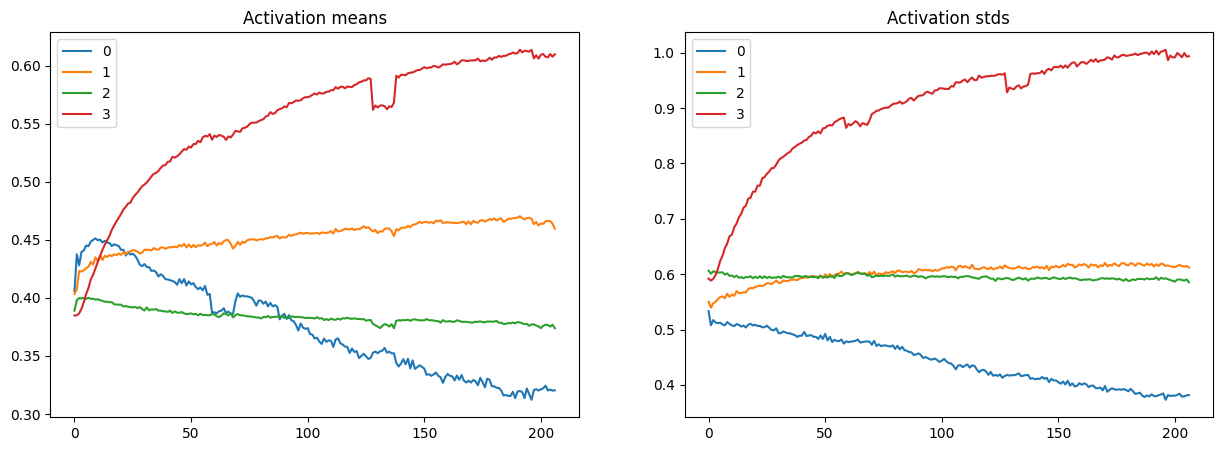

In [17]:
act_stats.plot_statistics()